 ╔══<i><b>Alai-DeepLearning</b></i>════════════════════════════╗
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 7. Neural Network Improvements**
# Section 7. Optimizer (1) Momentum

### _Objective_
1. Momentum 알고리즘의 원리인 지수이동평균에 대해 배워보겠습니다. <br>
2. Gradient Descent 알고리즘의 개량 버전인 Momentum 알고리즘을 배워보겠습니다. <br>
  
╚═════════════════════════════════════════╝

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(30)
tf.random.set_random_seed(30)

<br><br>

# \[ 1. 지수이동평균 \]

----

----

> *지수 이동 평균이란, 시계열적 데이터에서 전체적인 추세를 확인하는 방법론입니다.* <br>
> *증권가의 차트를 분석할 때 많이 등장하는 것으로, 변화가 극심한 차트 정보에서, 큰 추세의 변화를 알아내는 방법론입니다.* <br>

### 예제 데이터) 2004.01~2018.05까지의 코스피 지수

In [2]:
!wget https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/KOSPI_dataset.csv

--2019-04-08 15:18:56--  https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/KOSPI_dataset.csv
Resolving s3.ap-northeast-2.amazonaws.com (s3.ap-northeast-2.amazonaws.com)... 52.219.58.33
Connecting to s3.ap-northeast-2.amazonaws.com (s3.ap-northeast-2.amazonaws.com)|52.219.58.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3152 (3.1K) [text/csv]
Saving to: ‘KOSPI_dataset.csv.1’

KOSPI_dataset.csv.1 100%[===================>]   3.08K  --.-KB/s    in 0s      

2019-04-08 15:18:56 (37.6 MB/s) - ‘KOSPI_dataset.csv.1’ saved [3152/3152]



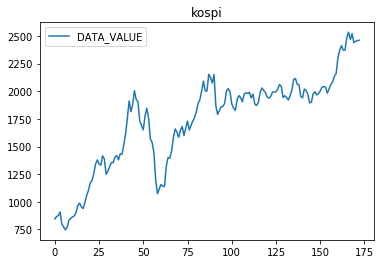

In [3]:
df = pd.read_csv("./KOSPI_dataset.csv",index_col=0)
df.plot(y='DATA_VALUE',title="kospi")
plt.show()

<br>

## 1. 지수이동평균 (EMA, exponential Moving Average) 수식
---
* 지수이동평균의 수식은 아래와 같습니다.<br>
$
s_{n+1} = (1-\beta) x_n + \beta s_n\\
x_n: \mbox{최신 정보} \\
s_n: \mbox{과거 종합 정보} \\
\beta : \mbox{계수},0<\beta<1
$


* 위의 지수이동평균값($s_{n+1}$)의 재귀식을 풀어보면 아래와 같이 나옵니다.
$
s_{n+1} = (1-\beta) ( x_n + \beta x_{n-1}+\beta^2x_{n-2}+ \cdots + \beta^{n}x_{0})
$
* 과거의 정보일수록 가중치가 점점 작아지는 특성을 가집니다.


<br>

## 2. 지수이동 평균 계산하기
---


### (1) $\beta$가 0.9일 때

In [4]:
beta = 0.9
ema = 0
ema_list = []

for x in df.DATA_VALUE:
    ema = (1-beta)*x + beta*ema
    ema_list.append(ema)

df['beta=0.9'] = ema_list    

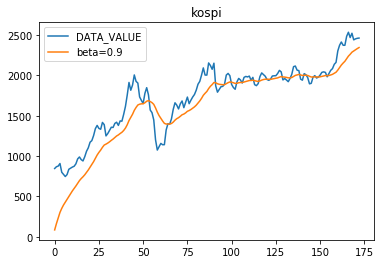

In [5]:
df.plot(y=['DATA_VALUE','beta=0.9'],title="kospi")
plt.show()

### (2) $\beta$가 0.5일 때

In [6]:
beta = 0.5
ema = 0
ema_list = []

for x in df.DATA_VALUE:
    ema = (1-beta)*x + beta*ema
    ema_list.append(ema)

df['beta=0.5'] = ema_list    

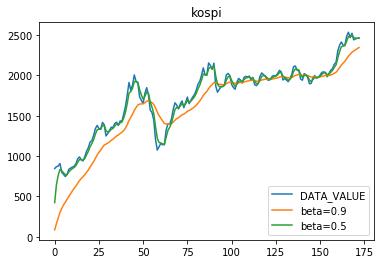

In [7]:
df.plot(y=['DATA_VALUE','beta=0.9','beta=0.5'],title="kospi")
plt.show()

beta 값이 작아질수록 좀 더 변화에 민감하게 움직인다는 것을 알 수 있습니다.

## 3. 편향 보정 수식
---

*  EMA 값을 구할 때, 초기 EMA 값이 너무 적게 계산됩니다.<br>
* 이 문제를 해결하기 위해 기본적으로 편향 보정 가중치를 곱해주게 됩니다.<br>
$
s_{n+1} =\frac{1}{1-\beta^{n+1}}((1-\beta) x_n + \beta s_n)
$

### (1)  $\beta$가 0.9일 때

In [8]:
beta = 0.9
ema = 0
ema_list = []

for idx, x in enumerate(df.DATA_VALUE):
    ema = (1-beta)*x + beta*ema
    adjusted_ema = ema / (1-beta**(idx+1))
    ema_list.append(adjusted_ema)

df['beta=0.9'] = ema_list    

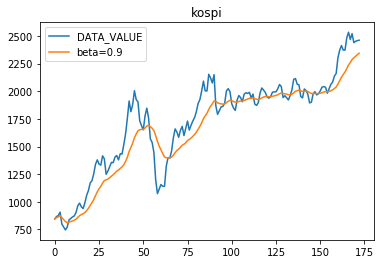

In [9]:
df.plot(y=['DATA_VALUE','beta=0.9'],title="kospi")
plt.show()

### (2) $\beta$가 0.5일 때

In [10]:
beta = 0.5
ema = 0
ema_list = []

for idx,x in enumerate(df.DATA_VALUE):
    ema = (1-beta)*x + beta*ema
    adjusted_ema = ema / (1-beta**(idx+1))
    ema_list.append(adjusted_ema)

df['beta=0.5'] = ema_list    

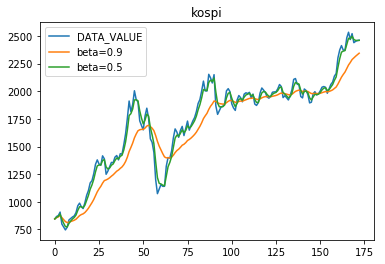

In [11]:
df.plot(y=['DATA_VALUE','beta=0.9','beta=0.5'],title="kospi")
plt.show()

편향 보정을 통해, 초기에 값이 지나치게 작게 평가되는 문제를 방지하였습니다.

<br><br>

# \[ 2. Momentum Optimizer 수식 \]

----

----

> *모멘텀 알고리즘은 Gradient Descent 알고리즘에 지수이동평균 수식을 포함한 수식입니다.*<br>
> *모멘텀은 Gradient Descent이 보다 빨리 수렴될 수 있도록 도와줍니다.* <br> 

<br>

## 1. Momentum Optimizer 수식
---

$$
V_{t+1} = \beta V_t +\frac{\partial L}{\partial W} \\
W_{t+1} = W_{t} - \alpha V_{t+1}
$$

* 모멘텀 Optimizer의 수식은 지수이동평균 공식을 이용하되, 좀 더 간결하게 표기하였습니다.$(1-\beta)$를 제거하였습니다.

* 모멘텀은 물리에서 관성을 의미합니다. 관성의 힘으로 평탄하지 않은 Loss Function 위를<br>
매끈하게 지나갈 수 있도록 도와줍니다.<br>
* $\beta$에 따라, 관성의 크기를 결정할 수 있습니다. 관성이 클수록, 가속이 빨라지지만<br>
변화에 대처하는 속도가 느려, 수렴이 느려질 수 있습니다. 보통 0.9정도를 이용합니다. <br>

![Imgur](https://i.imgur.com/WHfLZpK.png)

<br>

## 2. NAG Momentum Optimizer 수식
---

$$
V_{t+1} = \beta v_t +\triangledown_{W}J(W-\beta v_{t}) \\
W_{t+1} = W_{t} - \alpha V_{t+1}
$$

![Imgur](https://i.imgur.com/xSH4hck.jpg)

* NAG 모멘텀 알고리즘은 모멘텀 알고리즘의 수정 본입니다. 차이는 어느 시점의 기울기를 이용할 것인가에 따라 달라집니다. NAG 모멘텀은 momentum에 의해 이동한 상태에서의 gradient을 구한다는 데에서 차이가 있습니다.<br>
* NAG를 이용할 경우, Momentum 방식보다 늘 좀더 효과적인 것으로 알려져 있습니다. NAG 알고리즘이 Momentum보다 훨씬 안정적으로 수렴하기 때문입니다.

<br><br>

# \[ 3. Momentum Optimizer을 시각화하기 \]

----

----


## \[ Optional. Beale Function Visualization \]
---
> 최적화 함수(Optimizer)를 평가하기 위해, 보통 Beale Function과 같은 test function을 많이 이용합니다.<br>

$$
f(x,y) = (1.5 - x + xy)^2+(2.25-x+xy^2)^2+(2.625-x+xy^3)^2
$$

In [12]:
def beale(x, y):
    return ((1.5 - x + x * y) ** 2 + 
            (2.25 - x + x * y ** 2) ** 2 + 
            (2.625 - x + x * y ** 3) ** 2)

In [13]:
def generate_beale_plot():
    # Beale function을 공간으로 치환한 것을 
    xmin, xmax, xstep = -4.5, 4.5, .2
    ymin, ymax, ystep = -4.5, 4.5, .2

    xs_ = np.arange(xmin, xmax, xstep)
    ys_ = np.arange(ymin, ymax, ystep)

    x, y = np.meshgrid(xs_, ys_)
    z = beale(x, y)

    minima = np.array([3., .5])
    minima_ = minima.reshape(-1, 1)
    z_minima = beale(*minima)
    # z_minima = minima.reshape(-1, 1)

    plt.figure(figsize=(8, 5))
    ax = plt.axes(projection='3d', elev=50, azim=-50)

    ax.plot(*minima_, z_minima, 'r*', markersize=10)
    ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1,
                    edgecolor='None', alpha=0.3, cmap=plt.cm.jet)

    ax.view_init(30, 10)
    ax.set_title("Beale Function Visualization")
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))

    return ax

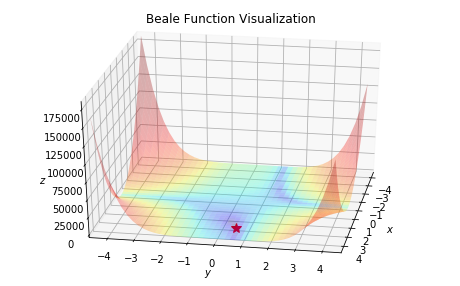

In [14]:
ax = generate_beale_plot()

## 1. Gradient Descent Optimizer 시각화하기
---

In [15]:
def gradient_descent_graph(start_x, start_y, func, lr):
    graph = tf.Graph()
    with graph.as_default():
        x = tf.Variable(initial_value=tf.constant(start_x), name='x')
        y = tf.Variable(initial_value=tf.constant(start_y), name='y')

        # Get Gradient x,y with tf_f
        z = func(x, y)
        z = tf.identity(z, name='z')
        train_op = (tf.train
                    .GradientDescentOptimizer(lr)
                    .minimize(z,name='train_op'))
    return graph

In [16]:
def trace(graph, max_iter):
    with tf.Session(graph=graph) as sess:
        sess.run(tf.global_variables_initializer())

        x = graph.get_tensor_by_name('x:0')
        y = graph.get_tensor_by_name('y:0')
        z = graph.get_tensor_by_name('z:0')
        train_op = graph.get_collection(tf.GraphKeys.TRAIN_OP)[0]

        xs, ys, zs = [], [], []
        for i in range(max_iter):
            x_, y_, z_ = sess.run([x, y, z])

            xs.append(x_)
            ys.append(y_)
            zs.append(z_)

            sess.run(train_op)
    return xs, ys, zs

In [19]:
start_x, start_y = -2., -4.

learning_rate = 0.00005
max_iter = 10000

graph = gradient_descent_graph(start_x,start_y, beale, learning_rate)

gd_xs, gd_ys, gd_zs = trace(graph, max_iter)

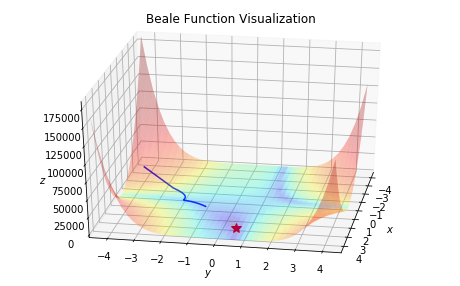

In [20]:
ax = generate_beale_plot()
ax.plot(gd_xs, gd_ys, gd_zs, 
        label='Gradient Descent', 
        color='b')
plt.show()

## 2. Momentum Optimizer 시각화하기
---

In [22]:
def momentum_graph(start_x, start_y, func, lr, momentum=0.9):
    graph = tf.Graph()
    with graph.as_default():
        x = tf.Variable(initial_value=tf.constant(start_x), name='x')
        y = tf.Variable(initial_value=tf.constant(start_y), name='y')

        # Get Gradient x,y with tf_f
        z = func(x, y)
        z = tf.identity(z, name='z')
        train_op = (tf.train
                    .MomentumOptimizer(lr, momentum=momentum)
                    .minimize(z,name='train_op'))
    return graph

### (1) Momentum이 0.9일 때 시각화

In [23]:
start_x, start_y = -2.5, -4.

momentum = 0.9
learning_rate = 0.00005 * (1-momentum)
max_iter = 10000

graph = momentum_graph(start_x,start_y, beale, learning_rate,momentum)

momentum_xs, momentum_ys, momentum_zs = trace(graph, max_iter)

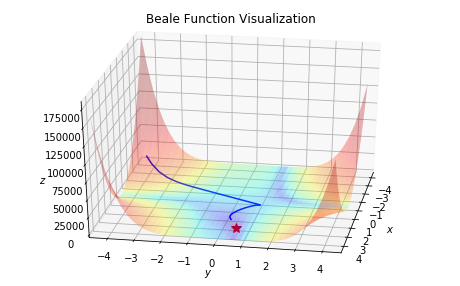

In [24]:
ax = generate_beale_plot()
ax.plot(momentum_xs, momentum_ys, momentum_zs, 
        label='momentum(beta={})'.format(momentum), 
        color='b')

### (2) Momentum에 따른 변화

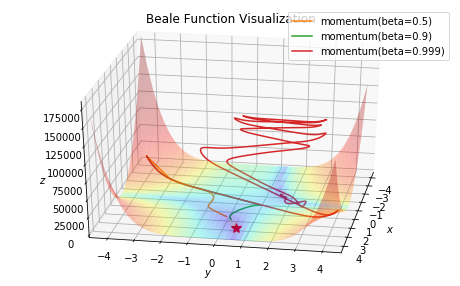

In [25]:
ax = generate_beale_plot()

for momentum in [0.5,0.9,0.999]:
    learning_rate = 0.00005 * (1-momentum)
    max_iter = 10000

    graph = momentum_graph(start_x,start_y,beale,
                           learning_rate,momentum)
    momentum_xs, momentum_ys, momentum_zs = trace(graph, max_iter)
    
    ax.plot(momentum_xs, momentum_ys, momentum_zs, 
            label='momentum(beta={})'.format(momentum))
plt.legend()
plt.show()    

## 3. NAG Momentum Optimizer 시각화하기
---

In [26]:
def nag_momentum_graph(start_x, start_y, func, lr, momentum=0.9):
    graph = tf.Graph()
    with graph.as_default():
        x = tf.Variable(initial_value=tf.constant(start_x), name='x')
        y = tf.Variable(initial_value=tf.constant(start_y), name='y')
        
        z = func(x, y)
        z = tf.identity(z, name='z')
        train_op = (tf.train
                    .MomentumOptimizer(lr, momentum=momentum,use_nesterov=True)
                    .minimize(z,name='train_op'))
    return graph

### (1) Momentum이 0.9일 때 시각화

In [27]:
start_x, start_y = -2.5, -4.

momentum = 0.9
learning_rate = 0.00005 * (1-momentum)
max_iter = 10000

graph = nag_momentum_graph(start_x,start_y, beale, learning_rate,momentum)

nag_xs, nag_ys, nag_zs = trace(graph, max_iter)

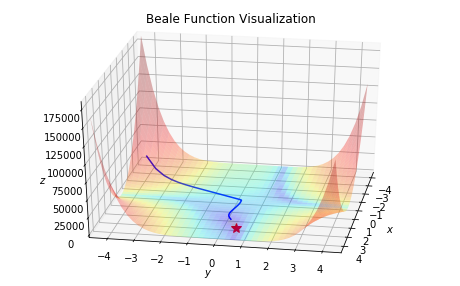

In [28]:
ax = generate_beale_plot()
ax.plot(nag_xs, nag_ys, nag_zs, 
        label='NAG momentum(beta={})'.format(momentum), 
        color='b')

### (2) Momentum에 따른 변화

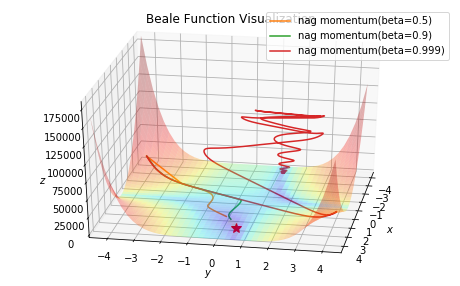

In [30]:
ax = generate_beale_plot()

for momentum in [0.5,0.9,0.999]:
    learning_rate = 0.00005 * (1-momentum)
    max_iter = 10000

    graph = nag_momentum_graph(start_x,start_y,beale,
                           learning_rate,momentum)
    nag_xs, nag_ys, nag_zs = trace(graph, max_iter)
    
    ax.plot(nag_xs, nag_ys, nag_zs, 
            label='nag momentum(beta={})'.format(momentum))
plt.legend()
plt.show()    

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/04/05

---